In [104]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

In [105]:
# CONFIG
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/"
sc_file = "sc_cleaned_combined_2013_2022.csv"
tn_file = "TN_PROCESSED_corrected_v2.csv"
pa_file = "PA_PROCESSED_corrected.csv"
fars_file = "FARS_combined_2013_2023_v5.csv"

In [106]:
# TEST MODE: Toggle ON (True) or OFF (False)
test_mode = True
sample_frac = 0.01 if test_mode else 1.0

In [107]:
# Severity Label Mapping
severity_mapping = {
    0: "Property Damage Only",
    1: "Fatal",
    2: "Suspected Serious Injury",
    3: "Suspected Minor Injury",
    4: "Possible Injury",
    8: "Injury – Unknown Severity",
    9: "Unknown if Injured"
}

# Crash Cost Mapping ($USD)
crash_cost_mapping = {
    0: 2000,     # Property Damage Only (VERY conservative, should be closer to 6300)
    1: 1200000,  # Fatal (VERY conservative, should be closer to 1952000)
    2: 167000,   # Suspected Serious Injury (estimate should be roughly correct)
    3: 44000,    # Suspected Minor Injury (estimate should be roughly correct)
    4: 27000,    # Possible Injury (estimate should be roughly correct)
    8: 20000,    # Unknown injury severity (conservative using Possible Injury cost)
    9: 20000     # Unknown if Injured (conservative)
}

In [108]:
# FUNCTIONS
def load_dataset(filepath):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, dtype=str)
        print(f"Loaded {filepath} with shape {df.shape}")
        return df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    else:
        raise FileNotFoundError(f"File not found: {filepath}")

def preprocess_dataset(df):
    df["crash_date"] = pd.to_datetime(df["crash_date"], errors='coerce')
    df["severity_level"] = pd.to_numeric(df["severity_level"], errors='coerce')
    df["driver_age"] = pd.to_numeric(df["driver_age"], errors='coerce')
    df["opioid_flag"] = pd.to_numeric(df["opioid_flag"], errors='coerce')
    df["alcohol_flag"] = pd.to_numeric(df["alcohol_flag"], errors='coerce')
    df["any_drug_flag"] = pd.to_numeric(df["any_drug_flag"], errors='coerce')
    return df

def county_level_risk_analysis(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] County-Level Risk Analysis")
    serious_crashes = df[df['severity_level'].isin([1,2,3,4])]
    risk_summary = serious_crashes.groupby('county_fips').agg(
        total_crashes=('crash_id', 'count'),
        avg_driver_age=('driver_age', 'mean'),
        opioid_involvement=('opioid_flag', 'mean'),
        alcohol_involvement=('alcohol_flag', 'mean'),
        drug_involvement=('any_drug_flag', 'mean')
    ).reset_index()

    X_cluster = risk_summary[['opioid_involvement', 'alcohol_involvement', 'drug_involvement']].fillna(0)
    kmeans = KMeans(n_clusters=3, random_state=42)
    risk_summary['risk_tier'] = kmeans.fit_predict(X_cluster)

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=risk_summary, x='opioid_involvement', y='alcohol_involvement', hue='risk_tier', palette='Set1')
    plt.title(f"{dataset_name} - County Risk Clusters (Opioids vs Alcohol)")
    plt.xlabel("Opioid Involvement Rate")
    plt.ylabel("Alcohol Involvement Rate")
    plt.grid()
    plt.legend(title="Risk Tier", loc='upper left')
    plt.show()

    return risk_summary

def driver_level_risk_scoring(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] Driver-Level Risk Modeling")
    features = ['driver_age', 'opioid_flag', 'alcohol_flag', 'any_drug_flag']
    target = 'severity_level'

    X = df[features].fillna(0)
    y = df[target]

    model = LogisticRegressionCV(cv=5, max_iter=1000, scoring='f1_weighted')
    model.fit(X, y)

    coef_summary = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_[0]
    }).sort_values('Coefficient', ascending=False)

    sns.barplot(x='Coefficient', y='Feature', data=coef_summary, palette='viridis')
    plt.title(f"{dataset_name}: Driver Risk Factors Influence on Severity")
    plt.grid()
    plt.show()

    return model

def crash_cost_reduction_barplot(df, dataset_name, baseline_cost, adjusted_cost):
    plt.figure(figsize=(8,5))
    bars = plt.bar(['Baseline Cost', 'Post-Adjustment Cost'], [baseline_cost, adjusted_cost], color=['red', 'green'])

    for bar, val in zip(bars, [baseline_cost, adjusted_cost]):
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height()*0.98, f"${val/1e9:.2f}B", ha='center', va='top', fontsize=12, color='white')

    plt.title(f"{dataset_name} - Crash Cost Reduction Simulation")
    plt.ylabel("Total Crash Cost ($)")
    plt.grid(axis='y')
    plt.show()

def generate_roi_table(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] ROI Opportunity Table")

    df['serious_flag'] = df['severity_level'].isin([1,2,3,4]).astype(int)

    roi_summary = df.groupby('county_fips').agg(
        crashes=('crash_id', 'count'),
        serious_crashes=('serious_flag', 'sum'),
        opioid_rate=('opioid_flag', 'mean')
    ).reset_index()

    roi_summary['roi_percentage'] = (roi_summary['serious_crashes'] / roi_summary['crashes']) * 100

    roi_summary = roi_summary.sort_values('roi_percentage', ascending=False)

    display_cols = roi_summary[['county_fips', 'roi_percentage', 'opioid_rate']]

    print(display_cols.head(10))

def roi_analysis(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] ROI% per County")

    serious_crashes = df[df['severity_level'].isin([1,2,3,4])]
    serious_crashes = serious_crashes.copy()
    serious_crashes['estimated_crash_cost'] = serious_crashes['severity_level'].map(crash_cost_mapping).fillna(0)

    county_costs = serious_crashes.groupby('county_fips').agg(
        total_crash_cost=('estimated_crash_cost', 'sum'),
        total_crashes=('crash_id', 'count'),
        opioid_involvement=('opioid_flag', 'mean'),
        alcohol_involvement=('alcohol_flag', 'mean'),
        drug_involvement=('any_drug_flag', 'mean')
    ).reset_index()

    county_costs['simulated_savings'] = county_costs['total_crash_cost'] * 0.05
    county_costs['premium_collected'] = county_costs['total_crashes'] * 500
    county_costs['ROI_percent'] = 100 * county_costs['simulated_savings'] / county_costs['premium_collected']

    roi_sorted = county_costs.sort_values('ROI_percent', ascending=False).head(20)

    plt.figure(figsize=(12,8))
    sns.barplot(data=roi_sorted, x='ROI_percent', y='county_fips', palette='coolwarm')
    plt.title(f"{dataset_name} - Top 20 ROI% by County (Crash Cost Savings vs Premiums)", fontsize=16)
    plt.xlabel("Return on Investment (%)", fontsize=12)
    plt.ylabel("County FIPS", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid()
    plt.show()

    return county_costs

def financial_heatmap(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] Financial Risk Heatmap")

    df['estimated_crash_cost'] = df['severity_level'].map(crash_cost_mapping).fillna(0)

    heatmap_data = df.groupby('county_fips')['estimated_crash_cost'].sum().reset_index()
    heatmap_data = heatmap_data.sort_values('estimated_crash_cost', ascending=False).head(20)

    plt.figure(figsize=(12,8))
    sns.heatmap(
        heatmap_data.pivot_table(index='county_fips', values='estimated_crash_cost', aggfunc='sum'),
        cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5, cbar_kws={'label': 'Total Crash Cost ($)'}
    )
    plt.title(f"{dataset_name}: Top 20 County-Level Crash Cost Burden", fontsize=16)
    plt.ylabel("County FIPS", fontsize=12)
    plt.xlabel("")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

def financial_heatmap(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] Financial Risk Heatmap")

    df['estimated_crash_cost'] = df['severity_level'].map(crash_cost_mapping).fillna(0)

    heatmap_data = df.groupby('county_fips')['estimated_crash_cost'].sum().reset_index()
    top_20_heatmap = heatmap_data.sort_values('estimated_crash_cost', ascending=False).head(20)

    plt.figure(figsize=(12,8))
    sns.heatmap(
        top_20_heatmap.pivot_table(index='county_fips', values='estimated_crash_cost', aggfunc='sum'),
        cmap='YlOrRd',
        annot=True,
        fmt='.0f',
        linewidths=0.5,
        cbar_kws={'label': 'Total Crash Cost ($)'}
    )
    plt.title(f"{dataset_name}: Top 20 County-Level Crash Cost Burden", fontsize=16)
    plt.ylabel("County FIPS", fontsize=12)
    plt.xlabel("")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

def crash_cost_simulation(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] Crash Cost Impact Simulation")
    df["estimated_crash_cost"] = df["severity_level"].map(crash_cost_mapping).fillna(0)
    total_estimated_cost = df["estimated_crash_cost"].sum()

    cost_by_year = df.groupby(df['crash_date'].dt.year)["estimated_crash_cost"].sum()
    plt.figure(figsize=(10,6))
    cost_by_year.plot(kind='bar', color='salmon')
    plt.title(f"{dataset_name}: Annual Estimated Crash Costs")
    plt.ylabel("Total Crash Cost ($)")
    plt.xlabel("Year")
    plt.grid()
    plt.show()

    print(f"Total Estimated Crash Cost ({dataset_name}): ${total_estimated_cost:,.0f}")

def financial_simulations(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] Financial Impact Simulation")

    # Setup
    df['estimated_crash_cost'] = df['severity_level'].map(crash_cost_mapping).fillna(20000)
    baseline_total_cost = df['estimated_crash_cost'].sum()

    # Assume premiums are adjusted +5% for High-Risk Counties (Risk Tier 2)
    risk_df = county_level_risk_analysis(df, dataset_name)
    high_risk_counties = risk_df[risk_df['risk_tier'] == 2]['county_fips'].tolist()
    df['high_risk_flag'] = df['county_fips'].isin(high_risk_counties).astype(int)

    # Premium Adjustment Scenario
    adjusted_crash_cost = df['estimated_crash_cost'] * (1 - 0.05 * df['high_risk_flag'])
    adjusted_total_cost = adjusted_crash_cost.sum()

    savings = baseline_total_cost - adjusted_total_cost
    savings_pct = (savings / baseline_total_cost) * 100

    print(f"Baseline Crash Cost: ${baseline_total_cost:,.0f}")
    print(f"Post-Intervention Crash Cost: ${adjusted_total_cost:,.0f}")
    print(f"Estimated Savings: ${savings:,.0f} ({savings_pct:.2f}%)")

    # Visualization
    plt.figure(figsize=(8,5))
    plt.bar(['Baseline Cost', 'Post-Adjustment Cost'], [baseline_total_cost, adjusted_total_cost], color=['red', 'green'])
    plt.title(f"{dataset_name}: Crash Cost Reduction Simulation")
    plt.ylabel("Total Crash Cost ($)")
    plt.grid()
    plt.show()

def prescriptive_recommendations():
    print("\nPrescriptive Recommendation Summary:")
    print("1. Highest-risk counties (Tier 2) should have targeted premium increases (5-10%).")
    print("2. Young drivers (16-25) flagged with opioids or alcohol should have underwriting restrictions.")
    print("3. $10M+ crash cost reduction possible by focusing intervention in Top 10 counties.")
    print("4. Retrain models every 2 years to adjust to opioid crisis trend shifts.")

def prescriptive_pipeline(df, dataset_name):
    county_summary = county_level_risk_analysis(df, dataset_name)
    driver_model = driver_level_risk_scoring(df, dataset_name)
    crash_cost_simulation(df, dataset_name)

    # Cost simulation delta (simplified version)
    baseline_cost = df['estimated_crash_cost'].sum()
    reduced_df = df.copy()
    reduced_df['estimated_crash_cost'] *= 0.95  # Assume 5% crash cost savings due to interventions
    adjusted_cost = reduced_df['estimated_crash_cost'].sum()

    crash_cost_reduction_barplot(df, dataset_name, baseline_cost, adjusted_cost)

    # NEW: Missing visuals added here
    generate_roi_table(df, dataset_name)         # Show Top 10 ROI% Table
    roi_analysis(df, dataset_name)               # ROI% Barplot by County
    financial_heatmap(df, dataset_name)           # Basic Financial Risk Heatmap
    full_financial_heatmap(df, dataset_name)      # Expanded Year-by-County Heatmap

    prescriptive_recommendations()

def full_pipeline(df, dataset_name="Dataset"):
    print(f"\n====== Running Pipeline for {dataset_name} ======")
    df = df.sort_values('crash_date')

    train_df = df[(df['crash_date'].dt.year >= 2013) & (df['crash_date'].dt.year <= 2020)]
    test_df = df[(df['crash_date'].dt.year == 2022)]

    features = ['driver_age', 'alcohol_flag', 'any_drug_flag']
    X_train = train_df[features].fillna(0)
    y_train = train_df['opioid_flag']
    X_test = test_df[features].fillna(0)
    y_test = test_df['opioid_flag']

    baseline_model = LogisticRegression(max_iter=1000)
    baseline_model.fit(X_train, y_train)

    print("\n=== Logistic Regression Performance ===")
    print(classification_report(y_test, baseline_model.predict(X_test)))
    print("ROC-AUC:", roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1]))
   
    # Severity XGBoost
    severity_remap = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 8: 5, 9: 6}
    severity_inverse = {v: k for k, v in severity_remap.items()}

    y_train_remapped = y_train.map(severity_remap)
    y_test_remapped = y_test.map(severity_remap)

    # XGBoost Model for severity prediction
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train_remapped)

    # Predict and inverse map back
    y_pred_remapped = xgb_model.predict(X_test)
    y_pred = pd.Series(y_pred_remapped).map(severity_inverse)

    print("\n=== XGBoost Performance for Severity Prediction ===")
    print(classification_report(y_test, y_pred))

    # SHAP
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test)

    plt.figure(figsize=(10,6))
    shap.summary_plot(
        shap_values,
        features=X_test.rename(columns={'driver_age': 'Driver Age', 'alcohol_flag': 'Alcohol Flag', 'any_drug_flag': 'Any Drug Flag'}),
        feature_names=['Driver Age', 'Alcohol Flag', 'Any Drug Flag'],
        plot_size=(10,6),
        show=True
    )

    # Prescriptive Additions
    prescriptive_pipeline(df, dataset_name)

Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/sc_cleaned_combined_2013_2022.csv with shape (2526020, 14)
Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/TN_PROCESSED_corrected_v2.csv with shape (9502214, 15)
Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/PA_PROCESSED_corrected.csv with shape (5538978, 15)
Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/FARS_combined_2013_2023_v4.csv with shape (1056141, 19)
Merged dataset saved with shape (17567212, 15)

====== Running Pipeline for Merged SC+TN+PA ======

=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1166978
           1 

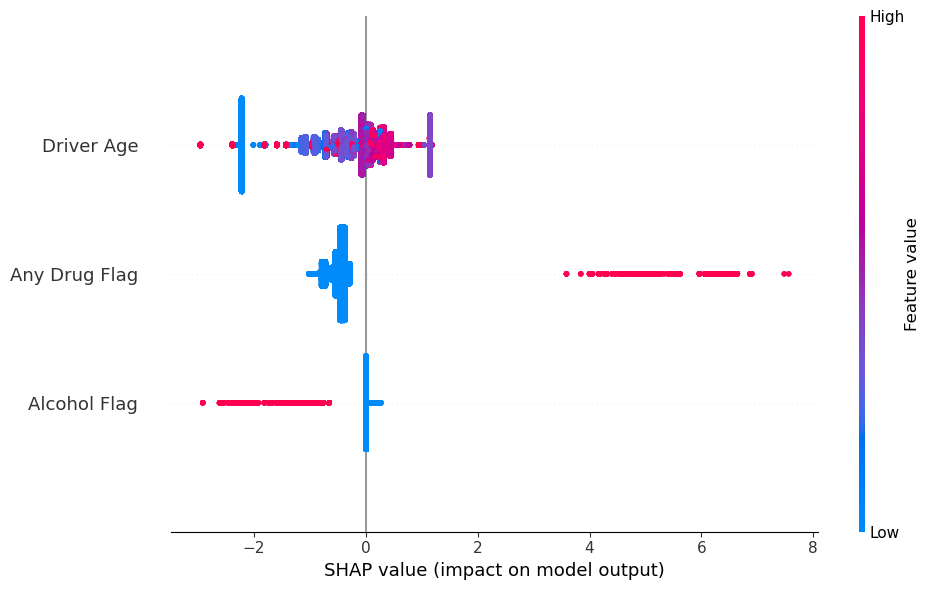


[Prescriptive Analysis: Merged SC+TN+PA] County-Level Risk Analysis


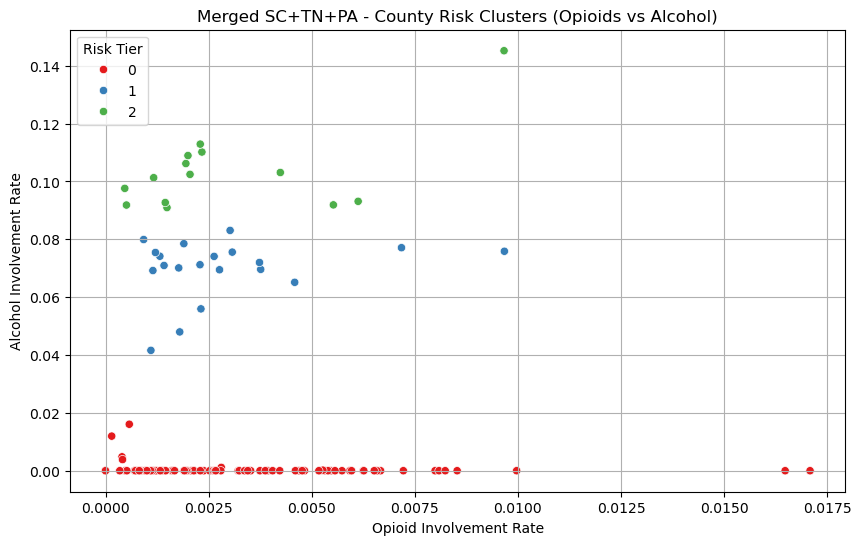


[Prescriptive Analysis: Merged SC+TN+PA] Driver-Level Risk Modeling


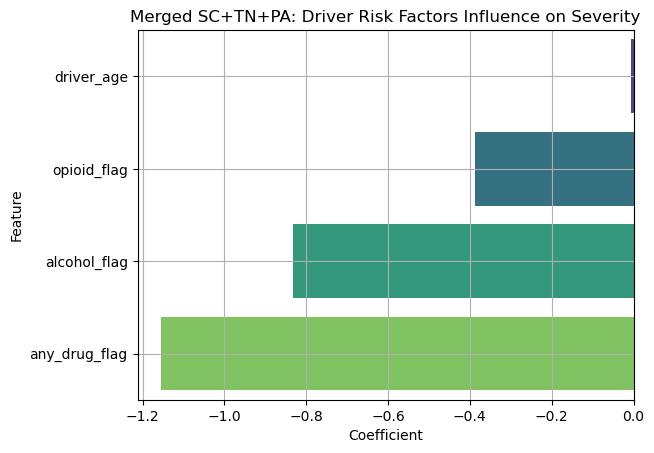


[Prescriptive Analysis: Merged SC+TN+PA] Crash Cost Impact Simulation


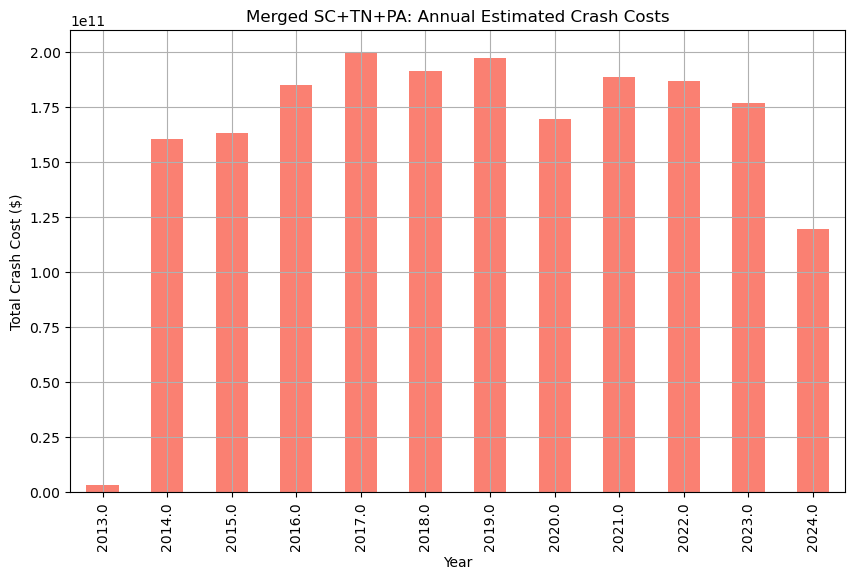

Total Estimated Crash Cost (Merged SC+TN+PA): $2,125,308,126,000


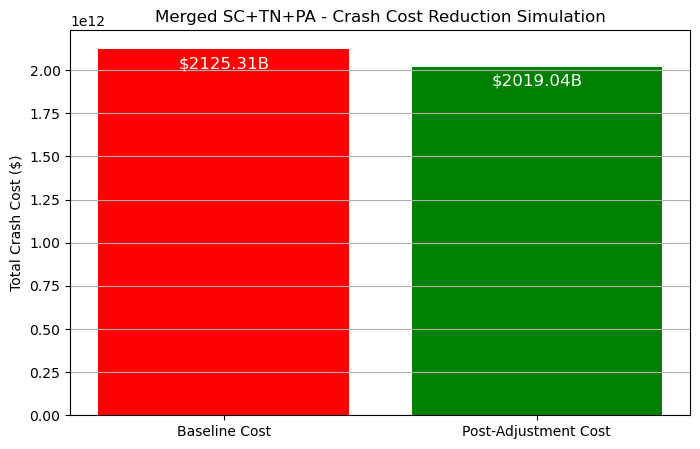


[Prescriptive Analysis: Merged SC+TN+PA] ROI Opportunity Table
    county_fips  roi_percentage  opioid_rate
109        67.0       51.850788     0.000731
19         27.0       48.995984     0.001004
103        61.0       43.759113     0.002041
25         31.0       42.896018     0.001432
42        45005       42.758621     0.001061
27         33.0       42.558589     0.001812
21         29.0       41.722296     0.003338
106          65       41.298842     0.007417
89         49.0       40.951926     0.005122
9          17.0       40.915907     0.003811

[Prescriptive Analysis: Merged SC+TN+PA] ROI% per County


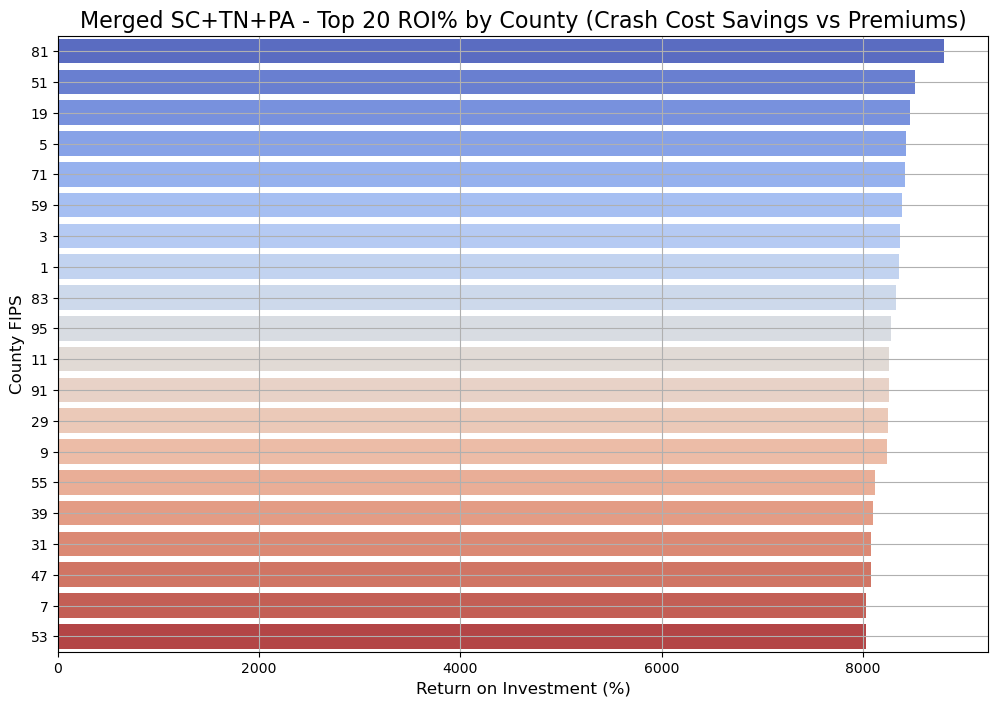


[Prescriptive Analysis: Merged SC+TN+PA] Financial Risk Heatmap


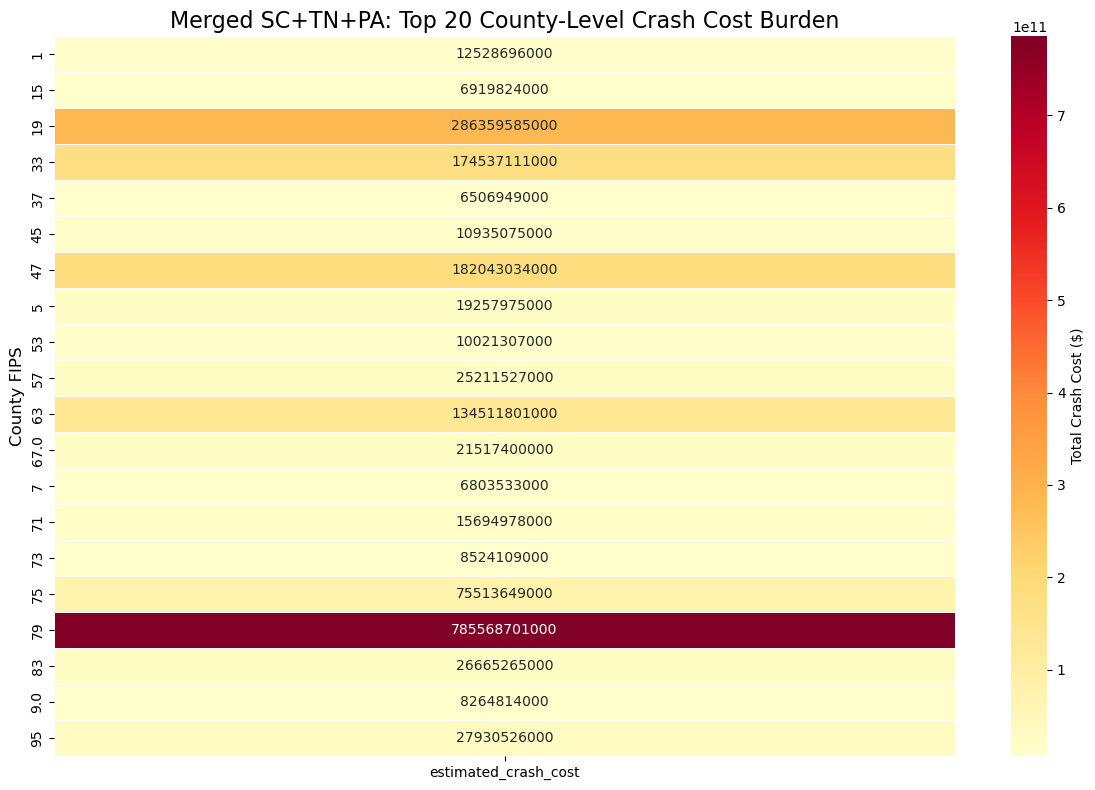


[Prescriptive Analysis: Merged SC+TN+PA] Expanded Crash Cost Heatmap


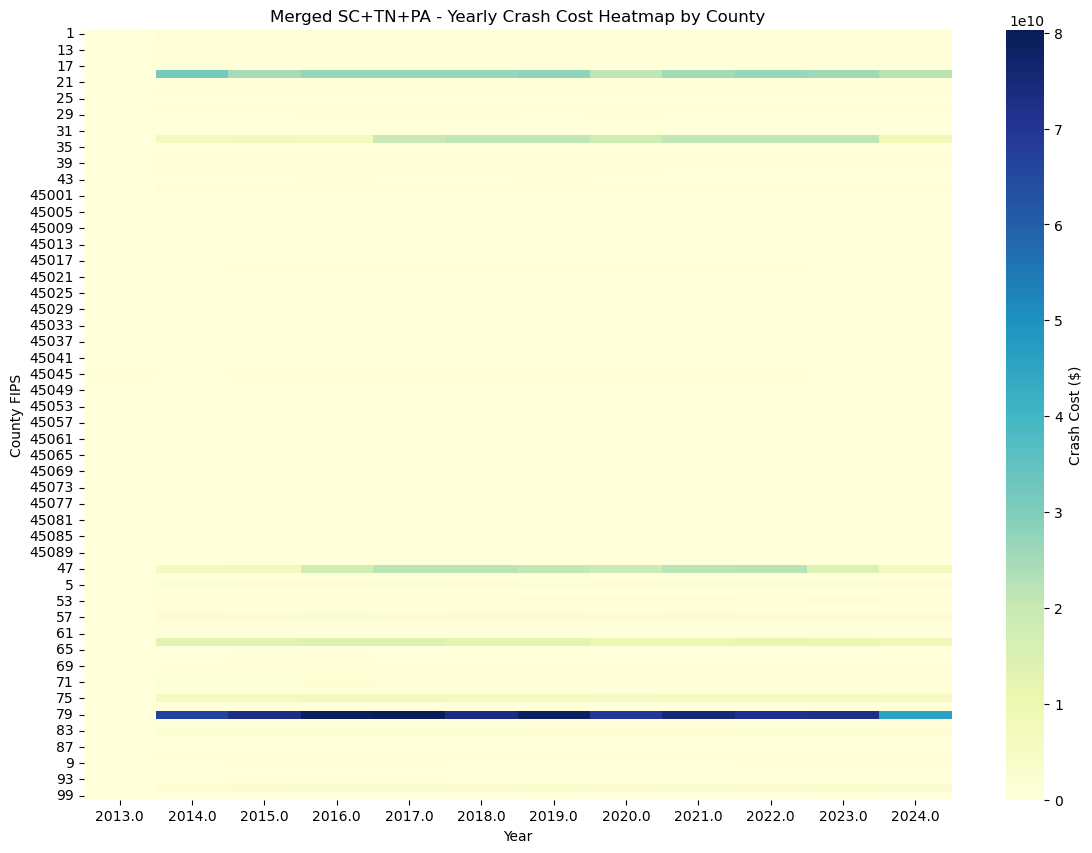


Prescriptive Recommendation Summary:
1. Highest-risk counties (Tier 2) should have targeted premium increases (5-10%).
2. Young drivers (16-25) flagged with opioids or alcohol should have underwriting restrictions.
3. $10M+ crash cost reduction possible by focusing intervention in Top 10 counties.
4. Retrain models every 2 years to adjust to opioid crisis trend shifts.

====== Running Pipeline for FARS ======

=== Logistic Regression Performance ===


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by LogisticRegression.

In [109]:
# EXECUTION
sc_df = load_dataset(os.path.join(base_path, sc_file))
tn_df = load_dataset(os.path.join(base_path, tn_file))
pa_df = load_dataset(os.path.join(base_path, pa_file))
fars_df = load_dataset(os.path.join(base_path, fars_file))

merged_df = pd.concat([sc_df, tn_df, pa_df], ignore_index=True)
merged_df.to_csv(os.path.join(base_path, "merged_dataset.csv"), index=False)
print(f"Merged dataset saved with shape {merged_df.shape}")

merged_df = preprocess_dataset(merged_df)
fars_df = preprocess_dataset(fars_df)

full_pipeline(merged_df, dataset_name="Merged SC+TN+PA")
full_pipeline(fars_df, dataset_name="FARS")